In [1]:
#!pip install cute_ranking --user

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

import json

from cute_ranking.core import ndcg_at_k

In [3]:
# Validation data
df_val = pd.read_csv('val_data_adjusted_combination.csv')

# Current implementation
with open('methodCurrentResults.json', 'r') as file:
    currentMethod = json.load(file)
    
# First proposed implementation
with open('method1Results.json', 'r') as file:
    proposedMethod1 = json.load(file)

# Second proposed implementation
with open('method2Results.json', 'r') as file:
    proposedMethod2 = json.load(file)

In [4]:
results = {}

# Iterate through each method
for i, method in enumerate([currentMethod, proposedMethod1, proposedMethod2]):
    # save temporary results for each method
    temp_results = {}
    
    # Iterate through each combination
    for combination in df_val['combination'].unique():   
        # Pivot dataframe for each combination to get relevance score for each applicant
        df_to_np = df_val[df_val['combination'] == combination] \
                    .pivot_table(index = 'id', columns = 'product', values = 'relevance_score', aggfunc = 'sum') \
                    .fillna(-1) \
                    .apply(lambda x: x+1)
        
        # Check for missing columns (product not chosen in dataset for given combination)
        check = [x for x in [12, 18, 24, 30, 36] if x not in df_to_np.columns]
        
        # If exists missing column, add to dataframe if 0 value
        if len(check) > 0:
            for col in check:
                df_to_np[col] = 0
                
        # Order products according to methodology results and transform to numpy
        df_to_np = df_to_np[method[combination].values()] \
                    .reset_index(drop = True) \
                    .to_numpy()
        
        # save temporary ndcg results for each applicant
        ndcg_temp = []
        
        # Iterate through applicants and calculate NDCG@3
        for j in range(len(df_to_np)):
            ndcg_temp.append(ndcg_at_k(df_to_np[j], 3, method = 1))
        
        # Store mean results for given combination in specified methodology
        temp_results[combination] = np.array(ndcg_temp).mean()
    
    # Store results in final json
    if i == 0:
        results['current'] = temp_results
    elif i == 1:
        results['proposed1'] = temp_results
    else:
        results['proposed2'] = temp_results

In [5]:
df_results = pd.DataFrame(results) \
                .reset_index() \
                .rename(columns = {'index': 'combination'}) \
                .sort_values('combination') \
                .reset_index(drop = True)
df_results['current_normalized'] = 0
df_results['proposed1_normalized'] = df_results[['proposed1', 'current']].apply(lambda row: row[0] - row[1], axis = 1)
df_results['proposed2_normalized'] = df_results[['proposed2', 'current']].apply(lambda row: row[0] - row[1], axis = 1)

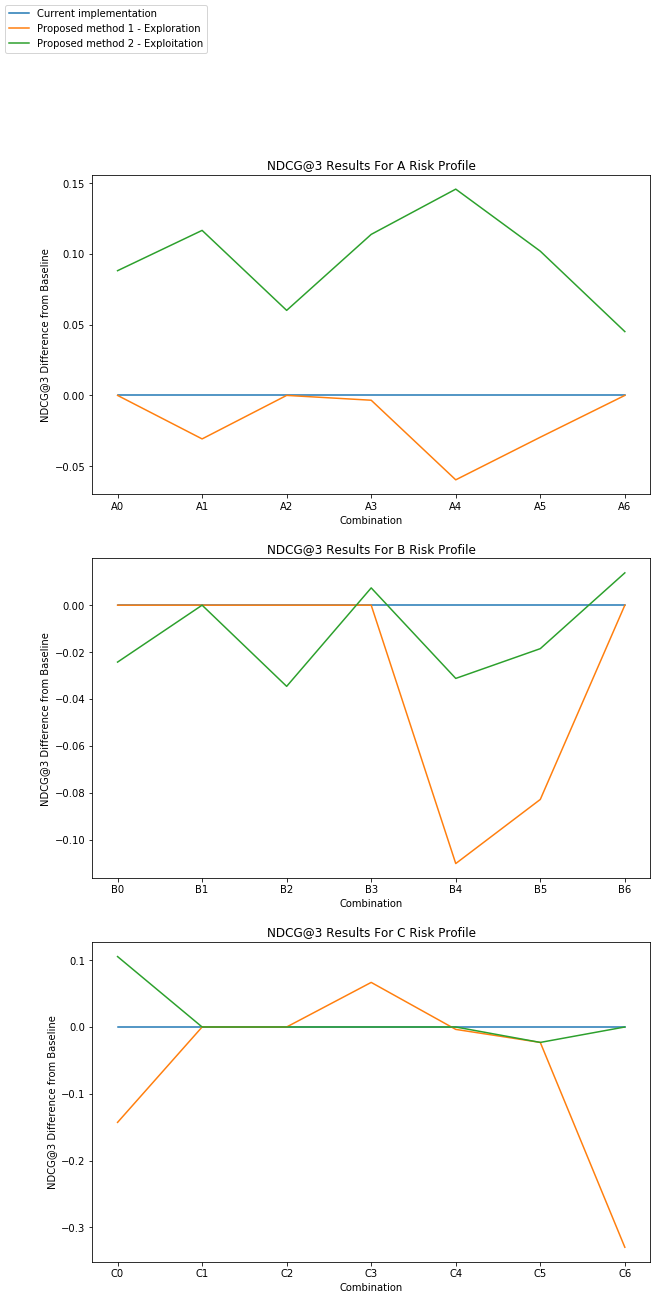

In [8]:
fig, ax = plt.subplots(3,1, figsize = (10, 20))

for i, risk in enumerate(['A', 'B', 'C']):
    x = [f'{risk}{i}' for i in range(0,7)]
    df_results \
        .loc[df_results['combination'] \
        .isin(x), :] \
        .set_index('combination')[['current_normalized', 'proposed1_normalized', 'proposed2_normalized']] \
        .rename(columns = {'current_normalized': 'Current implementation', 
                           'proposed1_normalized': 'Proposed method 1 - Exploration',
                           'proposed2_normalized': 'Proposed method 2 - Exploitation'}) \
        .plot(title = f'NDCG@3 Results For {risk} Risk Profile', ax = ax[i], legend=0)
    ax[i].set_xlabel('Combination')
    ax[i].set_ylabel('NDCG@3 Difference from Baseline')
    handles, labels = ax[i].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left')
plt.savefig('normalized_results.png', bbox_to_anchor = 'tight')
plt.show()